# Exercise 2: Conduction and Convection with RC-Networks

To practice the application of the numerical methods discussed in the lecture, you will write a small script to solve the temperature for a given RC-Network with conduction and convection.

The following example of an RC-Network as depicted in {numref}`ex2_rc_network` should be given. The network consists of resistances and conductances with non-capacitive nodes.

```{figure} Ex2/ex2_rc_network.png
---
height: 300px
name: ex2_rc_network
---
Figure from problem statement. {cite}`hagentoftIntroductionBuildingPhysics2001`, {cite}`claessonNetworkAnalysisNumerical1994`.
```

The problem should be solved using Equation {eq}`eq_rc_network`:

$$
\mathbf{Q} = \mathbf{K^{t}} \mathbf{T} + \mathbf{I_{0}}
$$(eq_rc_network)

## Program Design
First we are going to create some classes to easier describe the problem.
```{code} Python
class Node(object):

class K(object):

class Source(object):
```
- **Node**: A class to represent the nodes of the network. It should have a temperature and a list of conductances. It is important to note that we are using the `@property` decorator to make the conductances a property of the node. This way we can easily change the conductances of the node without having to change the code.
- **K**: A class to represent the conductances in the network. The start and end of the conductance as described in {cite}`claessonNetworkAnalysisNumerical1994` have to be defined. Furthermore, the conductance should a specified conduction value defining the heat conduction of the conductance. A mass flow rate is optional if heat convection should be calculated as well. The resulting conduction is calculated using the @property decorator to keep the code clean and the paremeter updated if changed.
- **Source**: A class to describe heat sources in the network. Heat sources are applied directly to nodes therefore the `index` represents the node the heat source is applied to.




In [54]:
import numpy as np
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt


# -----------------------------
#   Helper Classes
# -----------------------------

class Node(object):
    def __init__(self, Tn, index, *args, **kwargs):
        self.Tn = Tn    # in °C or K
        self._K = kwargs.get('K', None)
        self.index = index

    @property
    def K(self):
        if self._K is None:
            # self.K = [K for K in K_List if self.index == K.node_start or self.index == K.node_end]
            self.K = [K for K in K_List if self.index == K.node_start]
            self.K.append([K for K in K_BC_List if self.index == K.node_end][0])
        return self._K

    @K.setter
    def K(self, value):
        self._K = value


class K(object):
    def __init__(self, node_start, node_end, *args, **kwargs):
        # self.K_value = K_value
        self.cond = kwargs.get('cond', None)  # in W/K
        self.node_start = node_start
        self.node_end = node_end
        self._mass_flow = kwargs.get('mass_flow', None)  # in kg/s
        self._index = kwargs.get('index', None)
        self._K_value = kwargs.get('K_value', None)


    @property
    def index(self):
        if self._index is None:
            self.index = self.node_start + self.node_end
        return self._index

    @index.setter
    def index(self, value):
        self._index = value

    @property
    def K_value(self):
        if self._K_value is None:
            self.K_value = self.cond + self.mass_flow * 1000    # specific heat capacity dry ar approx. 1000 J/kgK
        return self._K_value

    @K_value.setter
    def K_value(self, value):
        self._K_value = value

    @property
    def mass_flow(self):
        if self._mass_flow is None:
            self.mass_flow = 0
        return self._mass_flow

    @mass_flow.setter
    def mass_flow(self, value):
        self._mass_flow = value


class Source(object):
    def __init__(self, index, heatflow, *args, **kwargs):
        self.index = index
        self.heatflow = heatflow



## User Input

Here the user can specify their input. Exemplary values are given based on the problem statement of the exercise.

- Variant 1 $\rightarrow$ without convection (BCs from Table {numref}`bc_table` without $\dot M$, pure conduction always 0.1 W/mK)
- Variant 2 $\rightarrow$ with convection (BCs from  Table {numref}`bc_table` + use $\dot M$ as specified in Table~\ref{tab:bc_example}, pure conduction always 0.1 W/mK)

```{table} Boundary conditions for problem statement
:name: bc_table
| Temperature          | Heat Source         | Mass flow for Variant2       |
|----------------------|---------------------|------------------------------|
| $T_{01} = 19\ C^{°}$ | $I_{0_{1}} = 10\ W$ | $\dot M_{12} = 0.05\ kg/s$   |
| $T_{02} = 25\ C^{°}$ | $I_{0_{2}} = 20\ W$ | $\dot M_{32} = 0.05\  kg/s $ |
| $T_{03} = 0\ C^{°}$  | $I_{0_{3}} = 10\ W$ | $\dot M_{13} = 0\  kg/s$     |
```


In [55]:
# Create nodes and conductances
# Main nodes
T1 = Node(Tn=20, index='1')
T2 = Node(Tn=20, index='2')
T3 = Node(Tn=20, index='3')
# Node_List = [T1, T2]
Node_List = [T1, T2, T3]

# Boundaries
T01 = Node(Tn=20, index='01')
T02 = Node(Tn=20, index='02')
T03 = Node(Tn=20, index='03')
# BC_Node_List = [T01, T02]
BC_Node_List = [T01, T02, T03]

# Conductances
K12 = K(cond=0.1, mass_flow=0.05, node_start='1', node_end='2')   # uncomment for Variant 2
# K12 = K(cond=0.1, mass_flow=0, node_start='1', node_end='2')
K21 = K(cond=0.1, mass_flow=0, node_start='2', node_end='1')
K13 = K(cond=0.1, mass_flow=0, node_start='1', node_end='3')
K31 = K(cond=0.1, mass_flow=0, node_start='3', node_end='1')
K23 = K(cond=0.1, mass_flow=0, node_start='2', node_end='3')
K32 = K(cond=0.1, mass_flow=0.05, node_start='3', node_end='2')   # uncomment for Variant 2
# K32 = K(cond=0.1, mass_flow=0, node_start='3', node_end='2')

# BC Conductances
K01 = K(K_value=0.1, node_start='01', node_end='1')
K02 = K(K_value=0.1, node_start='02', node_end='2')
K03 = K(K_value=0.1, node_start='03', node_end='3')
K_List = [K12, K21, K13, K31, K23, K32, K01, K02, K03]
# K_List = [K12, K21, K01, K02]
K_BC_List = [K01, K02, K03]
# K_BC_List = [K01, K02]

# Sources
I1 = Source(index='1', heatflow=10)
# I1 = Source(index='1', heatflow=0)
I2 = Source(index='2', heatflow=20)
# I2 = Source(index='2', heatflow=0)
I3 = Source(index='3', heatflow=10)
# I3 = Source(index='3', heatflow=0)

Sources_List = [I1, I2, I3]
# Sources_List = [I1, I2]

# End User Input
# -------------------------------------------------------

Since in this exercise the structuring of data is of importance, different ways to structure data are shown. Here for example we are using zip to create a joint dictionary with indexes and values from the K-instances.

In [56]:
K_index_list = [K.index for K in K_List]
K_value_list = [K.K_value for K in K_List]
K_value_dict = dict(
zip(K_index_list, K_value_list))  # Dictionary where the K values are stored with their index as keys.

## Numerics
### Building the LES
First we need to assemble our matrices to build the LES.

In [57]:
# -----------------------------
#         NUMERICS
# -----------------------------

# Stationary Calculation
unknowns = Node_List.__len__()
# Temperature Vector
Tn = np.array([Node.Tn for Node in Node_List])

# Conductivity Matrix
main_diag_k = np.zeros(Tn.size)  # Be careful when using zero- or one-like they are bound to the dtype of the copied
# array. Eg. if you are only putitng int as an initial condition into the array you copy numpy will assign the
# dtype int.ö The copy will only accept int or round to int.

# TODO: Check if this can be done smarter
for index, node in enumerate(Node_List):
    main_diag_k[index] = np.sum([K.K_value for K in node.K])
Kt_Array = np.eye(unknowns, unknowns) * -main_diag_k

for index, elem in np.ndenumerate(Kt_Array):
    i = index[0]  # Row index
    j = index[1]  # Column index
    str_index = str(i + 1) + str(j + 1)
    if str_index in K_value_dict.keys():
        # Kt_Array[i, j] = K_value_dict[str_index]
        Kt_Array[j, i] = K_value_dict[str_index]  # Symmetrical Matrix

# Boundary Conductivity Matrix
num_bc_nodes = BC_Node_List.__len__()
num_k_bc = K_BC_List.__len__()
K_BC_Array = np.zeros((unknowns, num_bc_nodes), dtype=object)
K_BC_Array[:] = [K for K in K_BC_List]
K_value_BC_Array = np.zeros((unknowns, num_bc_nodes))
K_value_BC_Array[:] = [K.K_value for K in K_BC_List]

K_BC_Adjacency = np.zeros((unknowns, num_bc_nodes))
for i, node in enumerate(Node_List):
    for j, K in np.ndenumerate(K_BC_Array):
        if node.index == K.node_start or node.index == K.node_end:
            K_BC_Adjacency[i, j[1]] = 1
# Sources
I_sources = np.zeros(unknowns)
for source in Sources_List:
    idx = int(source.index) - 1  # adjust index by subtracting 1
    I_sources[idx] = source.heatflow

# Boundary Temperatures
T_BC_vec = np.array([node.Tn for node in BC_Node_List])
K_BC = K_BC_Adjacency * K_value_BC_Array
Io = K_BC @ T_BC_vec + I_sources

### Solving the LES
For now, we will only solve the stationary case. This means $\mathbf{Q} \equiv 0$.
Inserting into Equation {eq}`eq_rc_network` we get:

$$
\mathbf{0} = \mathbf{K^{t}} \mathbf{T} + \mathbf{I}_o

$$(eq_rc_network_stationary)

Reshaping gives us a solution for $\mathbf{T}$:

$$
\mathbf{T} = -(\mathbf{K^{t})^{-1}} \mathbf{I}_o
$$(eq_rc_network_stationary_reshaped)

Instead of solving the LES directly as stated in Equation {eq}`eq_rc_network_stationary_reshaped` we will use the [numpy.linalg.solve()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) function. This function is more efficient and numerically more stable than the inverse.

In [58]:
# Calculation
print('Solving Stationary Calculation')
# T = -inv(Kt_Array) @ Io
T = solve(Kt_Array, -Io)

print(f'The temperature vector is: {T} ')
print('End of Stationary Calculation')

Solving Stationary Calculation
The temperature vector is: [  1.15079365 457.6984127    1.15079365] 
End of Stationary Calculation


### Postprocessing
A way of visualizing the results is to plot a heatmap of the temperature in the different node. This can be done using the [matplotlib.pyplot.imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function. Possibly not the best, but one way.

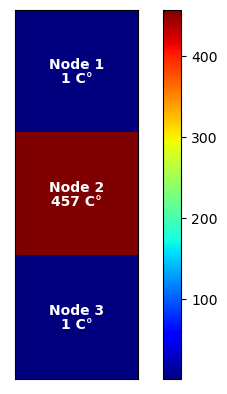

In [71]:
# https://chat.openai.com/

# Define the grid corresponding to the RC network, including indices
n_nodes = len(T)
grid_size = n_nodes
grid = np.zeros((grid_size, 2))
# grid[:, 0] = np.arange(grid_size)  # indices
grid[:, 0] = np.array([Node.index for Node in Node_List])  # indices
grid[:, 1] = T               # temperatures

# Define the color scale for the heatmap
cmap = plt.cm.get_cmap('jet')

# Plot the heatmap with indices as labels
fig, ax = plt.subplots()
im = ax.imshow(grid[:, 1].reshape((grid_size, 1)), cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
for i in range(grid_size):
    ax.text(0, i, f'Node {int(grid[i, 0])}', ha="center", va="bottom", color="w", weight='bold')
for i in range(grid_size):
    ax.text(0, i, f'{int(grid[i, 1])} C°', ha="center", va="top", color="w", weight='bold')
fig.colorbar(im)
plt.show()